# PHYS 512 - Final Project

**André Vallières (260742187)**

## Part 0

In [1]:
# Imports
%matplotlib inline
import matplotlib as mpl
from matplotlib import animation
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
from base64 import b64encode
from IPython.display import HTML

NBody class for simulating nbody problems. Time evolution follows the leapfrog method. The forces are computed by first defining a kernel which is the potential from a single particle of mass 1. The kernel is then convoluted with the density to arrive at the potential in space, $GM/r$. The accelerations, then, for each particle can be computed by calculating the gradient at each particle's position: $GM/r^2$. Leapfrog is then used to time evolve the system while keeping the total energy bounded.

In [3]:
class NBody:
    def __init__(self, nparticles, m=1.0, v=0.0, pos_init=None, soft=0.03, ngrid=51, G=1.0, dx=0.01, dt=0.01):
        # Parameters
        self.nparticles = nparticles
        self.ngrid = ngrid
        self.soft = soft
        self.G = G
        self.dt = dt
        self.dx = dx
        self.t = 0.0
        
        # Set kernel
        self.kernel = self.get_kernel()
        
        # Convert lists to numpy arrays
        if isinstance(m, list):
            m = np.array(m, dtype=np.float64)
        if isinstance(pos_init, list):
            pos_init = np.array(pos_init, dtype=np.float64)
        if isinstance(v, list):
            v = np.array(v, dtype=np.float64)
            
        # ngrid should be odd to ensure correct position-grid translation
        if self.ngrid % 2 == 0:
            self.ngrid += 1
        
        # Particles
        self.nparticles_init = self.nparticles
        
        if pos_init is not None:
            assert(pos_init.shape[1] == nparticles)
            self.pos = pos_init
        else:
            self.pos = self.get_positions((ngrid//3) * (np.random.randn(3, nparticles) + ngrid//2) % (ngrid - 1))
        self.pos_init = self.pos.copy()
        
        if isinstance(m, np.ndarray):
            assert(m.shape[1] == nparticles)
            self.masses = m
        else:
            self.masses = m * np.ones((1, nparticles))
        self.masses_init = self.masses.copy()
            
        if isinstance(v, np.ndarray):
            assert(v.shape[1] == nparticles)
            self.vels = v
        else:
            self.vels = v * np.ones((3, nparticles))
        self.vels_init = self.vels.copy()
        
        # Get accelerations
        self.accls = self.get_accls(self.pos)

    def get_kernel(self):
        if hasattr(self, 'kernel'):
            return self.kernel
        
        # Set up the grid
        x = np.arange(-self.ngrid//2 + 1, self.ngrid//2 + 1)
        x = np.abs(x) * self.dx
        xx,yy,zz = np.meshgrid(x, x, x)

        # Set up kernel
        r = np.sqrt(xx**2 + yy**2 + zz**2)
        r[r < self.soft] = self.soft
        self.kernel = -self.G / r

        return self.kernel
    
    def get_potential(self):
        self.rho = self.get_density()
        rhoft = np.fft.fftn(self.rho)
        
        return np.abs(np.fft.ifftn(rhoft * np.fft.fftn(np.fft.fftshift(self.kernel))))
    
    def get_density(self):
        # Iterate through particles to add their mass
        rho = np.zeros((self.ngrid,self.ngrid,self.ngrid))
        
        for i, mass in enumerate(self.masses[0]):
            idxs = self.get_indices(self.pos[:,i])
            
            # TODO: Could do something fancier like giving
            # weights depending on the distance to the position
            
            # x is left, right (l, r)
            # y is down, up (d, u)
            # z is front, back (f, b)
            l = tuple((idxs - [1,0,0]) % self.ngrid)
            r = tuple((idxs + [1,0,0]) % self.ngrid)
            d = tuple((idxs - [0,1,0]) % self.ngrid)
            u = tuple((idxs + [0,1,0]) % self.ngrid)
            f = tuple((idxs - [0,0,1]) % self.ngrid)
            b = tuple((idxs + [0,0,1]) % self.ngrid)
            
            # Give 1/12 of the mass to each neighbors
            rho[l] += mass / 12.0
            rho[r] += mass / 12.0
            rho[d] += mass / 12.0
            rho[u] += mass / 12.0
            rho[f] += mass / 12.0
            rho[b] += mass / 12.0
            
            # Keep 1/2 in the box itself
            rho[tuple(idxs)] += mass / 2.0
            
        return rho
        
    def get_accls(self, pos):
        # Convolution between density and kernel
        self.pot = self.get_potential()
        
        # Force is (negative) gradient of potential
        # We don't multiply by rho (mass), since we want the acceleration later
        ax = -(np.roll(self.pot, 1, axis=0) - np.roll(self.pot, -1, axis=0)) / (2 * self.dx) 
        ay = -(np.roll(self.pot, 1, axis=1) - np.roll(self.pot, -1, axis=1)) / (2 * self.dx)
        az = -(np.roll(self.pot, 1, axis=2) - np.roll(self.pot, -1, axis=2)) / (2 * self.dx)
        
        # Get particles positions
        idxs = self.get_indices(pos)
        
        ax = ax[idxs[0,:],idxs[1,:],idxs[2,:]]
        ay = ay[idxs[0,:],idxs[1,:],idxs[2,:]]
        az = az[idxs[0,:],idxs[1,:],idxs[2,:]]
        
        return np.array([ax,ay,az])

    def get_indices(self, pos):
        idxs = np.rint(pos / self.dx + (self.ngrid - 1)/2).astype(int)
        return idxs
    
    def get_positions(self, idxs):
        pos = np.round((idxs - (self.ngrid - 1)/2) * self.dx, 8)
        return pos
    
    def get_energy(self):
        ke = 0.5 * np.sum(self.masses * self.vels**2)
    
        pe = 0
        for i in range(self.nparticles):
            # Get particle position
            pos = self.pos[:,i]
            
            # Get indices
            idxs = self.get_indices(pos)
            
            # Get potential at that location and add
            p = self.masses[0, i] * self.pot[idxs[0], idxs[1], idxs[2]]
            pe += p
            
        return ke, pe
    
    def evolve(self):
        # Update velocities
        self.vels += self.accls * self.dt / 2.0
        
        # Update positions
        self.pos += self.vels * self.dt
        
        # Get accelerations
        try:
            self.accls = self.get_accls(self.pos)
        except:
            # Fix for boundary conditions (ugly)
            lim = np.round(self.ngrid * self.dx / 2.0, 8)
            for i in range(3):
                for j in range(self.nparticles):
                    while self.pos[i,j] > lim:
                        self.pos[i,j] -= 2*lim
                    while self.pos[i,j] < -lim:
                        self.pos[i,j] += 2*lim
                        
            self.accls = self.get_accls(self.pos)
        
        # Update velocities
        self.vels += self.accls * self.dt / 2.0
        
        # Update time
        self.t += self.dt
        
    def reset(self):
        # Reset positions, velocities, and accelerations
        self.pos = self.pos_init.copy()
        self.vels = self.vels_init.copy()
        self.accls = self.get_accls(self.pos)
        
        # Reset masses and number of particles
        self.masses = self.masses_init.copy()
        self.nparticles = self.nparticles_init
        
        # Reset time
        self.t = 0
        
        # Update other parameters
        self.rho = self.get_density()
        self.pot = self.get_potential()
        

Useful functions for visualization.

In [27]:
def visualize_space(nbody, fig=None, ax=None, plot=None, figsize=(8,8), title=None, 
                    plot_type="2d_scatter", cmap=cm.viridis, cb=None, history=False):
    if not fig and not ax:
        if "2d" in plot_type:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
        elif "3d" in plot_type:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(1, 1, 1, projection='3d')
        else:
            raise ValueError("Unexpected value of plot_type keyword argument")
        
    lim = np.round(nbody.ngrid * nbody.dx / 2.0, 8)
    
    if "scatter" in plot_type:
        space = nbody.pos
    elif "density" in plot_type:
        space = nbody.rho
    else:
        raise ValueError("Unexpected value of plot_type keyword argument")
    
    if "2d" in plot_type:
        if "scatter" in plot_type:
            if history or not plot:
                plot = ax.scatter(space[0,:], space[1,:], color='b', s=10)
            else:
                plot.set_offsets(space[0:2,:].T)
            
            ax.set_xlim((-lim,lim))
            ax.set_ylim((-lim,lim))
        elif "density" in plot_type:
            plot = ax.imshow(space.sum(axis=2), cmap=cmap, extent=[-lim,lim,-lim,lim], origin="lower")
            
            if cb is not None:
                cb.remove()
                plt.draw()
            cb = fig.colorbar(plot)
            
    elif "3d" in plot_type:
        if "scatter" in plot_type:
            if history or not plot:
                plot = ax.scatter(space[0,:], space[1,:], space[2,:], color='b', s=10)
            else:
                plot.set_offsets(space.T)
            
            ax.set_xlim3d((-lim,lim))
            ax.set_ylim3d((-lim,lim))
            ax.set_zlim3d((-lim,lim))
            
            ax.set_zlabel(r"$z$", fontsize=10)
        elif "density" in plot_type:
            pass
            # TODO
            
        #ax.clear()
        #surf = ax.plot_surface(X, Y, prob, rstride=5, cstride=5, cmap=cmap, alpha=0.7, norm=mpl.colors.Normalize(-wlim, wlim))
        #if colorbar:
        #    if cb is not None:
        #        cb.remove()
        #        plt.draw()
        #    cb = fig.colorbar(surf)
    else:
        raise ValueError("Unexpected value of plot_type keyword argument")
    
    ax.set_title(title)
    
    ax.set_xlabel(r"$x$", fontsize=10)
    ax.set_ylabel(r"$y$", fontsize=10)
    
    return fig, ax, cb, plot

cb = None 
plot = None
def evolve_space(nbody, animation_name, plot_type="2d_scatter", iters=50, figsize=(8,8), history=False, fps=10):
    # Animate
    if "2d" in plot_type:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    elif "3d" in plot_type:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1, projection='3d')
    else:
        raise ValueError("Unexpected value of plot_type keyword argument")
    
    global plot
    plot = None

    def plot_and_update_space(n, fig=None, ax=None):
        global cb, plot
        fig, ax, cb, plot = visualize_space(
            nbody, 
            title=r"$t = %f$s" % nbody.t, 
            fig=fig, 
            ax=ax, 
            plot=plot,
            cb=cb,
            figsize=figsize,
            history=history,
            plot_type=plot_type)
        nbody.evolve()
        return fig, ax
     
    anim = animation.FuncAnimation(fig, plot_and_update_space, frames=iters, fargs=(fig, ax,))
    anim.save(animation_name + ".mp4", writer=animation.FFMpegWriter(fps=fps))
    plt.close(fig)

def display_embedded_video(filename):
    video = open(filename, "rb").read()
    video_encoded = b64encode(video).decode("ascii")
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
    return HTML(video_tag)

## Part 1

Let's put a single particle in the grid.

In [61]:
G = 1e6
dx = 0.025
soft = 4 * dx
dt = 0.001
ngrid = 101

nbody = NBody(
    1, 
    ngrid=ngrid, 
    dx=dx, 
    soft=soft, 
    dt=dt, 
    pos_init=[[0],[0],[0]], 
    G=G
)

Let it now evolve and make sure position hasn't changed and kinetic energy is null, even with G insanely high.

In [38]:
for _ in range(100):
    nbody.evolve()
print("Position:", nbody.pos[:,0])
print("Kinetic energy:", nbody.get_energy()[0])

Position: [0.00000000e+00 4.24701720e-10 8.49403441e-10]
Kinetic energy: 7.910685995149329e-17


And we can also let it evolve and look at the movie.

In [29]:
G = 1e-2

nbody = NBody(
    1, 
    ngrid=ngrid, 
    dx=dx, 
    soft=soft, 
    dt=dt, 
    pos_init=[[0],[0],[0]], 
    v=[[0],[0],[0]],
    G=G
)

evolve_space(
    nbody, 
    "part1_single_particle",
    iters=50,
    history=True
)

# and 3d
evolve_space(
    nbody, 
    "part1_single_particle_3d",
    plot_type="3d_scatter",
    iters=50,
    history=True
)

In [89]:
display_embedded_video("part1_single_particle.mp4")

In [30]:
display_embedded_video("part1_single_particle_3d.mp4")

## Part 2

Now we put two particles in our grid.

To find the optimal starting velocity, I've used this code below (ran outside of this notebook). It basically scans through various velocities (close to the expected value) and find the velocity that gives the smallest absolute deviation.

In [ ]:
M = 10000
m = 1
r = 0.3

v = np.sqrt(G * (M + m) / r)

abs_diff_arr = []
v_arr = np.linspace(v-2.5, v+2.5, 100)

for v in v_arr:
    nbody = NBody(
        2, 
        ngrid=ngrid, 
        dx=dx, 
        soft=soft, 
        dt=dt, 
        m=[[M, m]],
        pos_init=[[0, r],[0, 0],[0, 0]], 
        v=[[0, 0],[0, v],[0, 0]],
        G=G
    )
    
    abs_diff = 0
    for _ in range(50):
        nbody.evolve()
        d = (np.sqrt(np.sum((nbody.pos[:,1] - nbody.pos[:,0])**2)) - r)
        abs_diff += np.abs(d)
        
    abs_diff_arr.append(abs_diff)
    
v_arr = np.array(v_arr)
abs_diff_arr = np.array(abs_diff_arr)

print(v_arr)
print(abs_diff_arr)

print("Optimal")
best = np.argmin(abs_diff_arr)
print(v_arr[best])
print(abs_diff_arr[best])

Now let's plot the result.

In [36]:
v = 16.580553653836304

nbody = NBody(
        2, 
        ngrid=ngrid, 
        dx=dx, 
        soft=soft, 
        dt=dt, 
        m=[[M, m]],
        pos_init=[[0, r],[0, 0],[0, 0]], 
        v=[[0, 0],[0, v],[0, 0]],
        G=G
    )

evolve_space(
    nbody, 
    "part2_two_particles",
    iters=150,
    history=True
)

# and 3d
evolve_space(
    nbody, 
    "part2_two_particles_3d",
    plot_type="3d_scatter",
    iters=150,
    history=True
)

In [38]:
display_embedded_video("part2_two_particles.mp4")

In [37]:
display_embedded_video("part2_two_particles_3d.mp4")

Note that the 3D plot is the continuation of the 2D plot (by looking at the time) and the orbit stays circular.

## Part 3

## Part 4

In [24]:
pos_init = np.array([[0.1],[0.0],[0.1]])
nbody = NBody(1, ngrid=51, dx=0.025, soft=0.1, dt=0.0025, pos_init=pos_init, G=10000)
for _ in range(100):
    nbody.evolve()
    print(nbody.get_accls(nbody.pos))
print(nbody.pos)
print(nbody.kin)

#nbody = NBody(2, m=1000, ngrid=51, dt=0.01)
#for _ in range(100):
#    nbody.evolve()
#print(nbody.vels)
#print(nbody.kin)

[[-1.16415322e-09]
 [-0.00000000e+00]
 [-0.00000000e+00]]
[[59714.99970934]
 [59714.99970934]
 [59714.99970934]]
[[59714.99970934]
 [59714.99970934]
 [59714.99970934]]


IndexError: index 74 is out of bounds for axis 0 with size 51

<IPython.core.display.Javascript object>


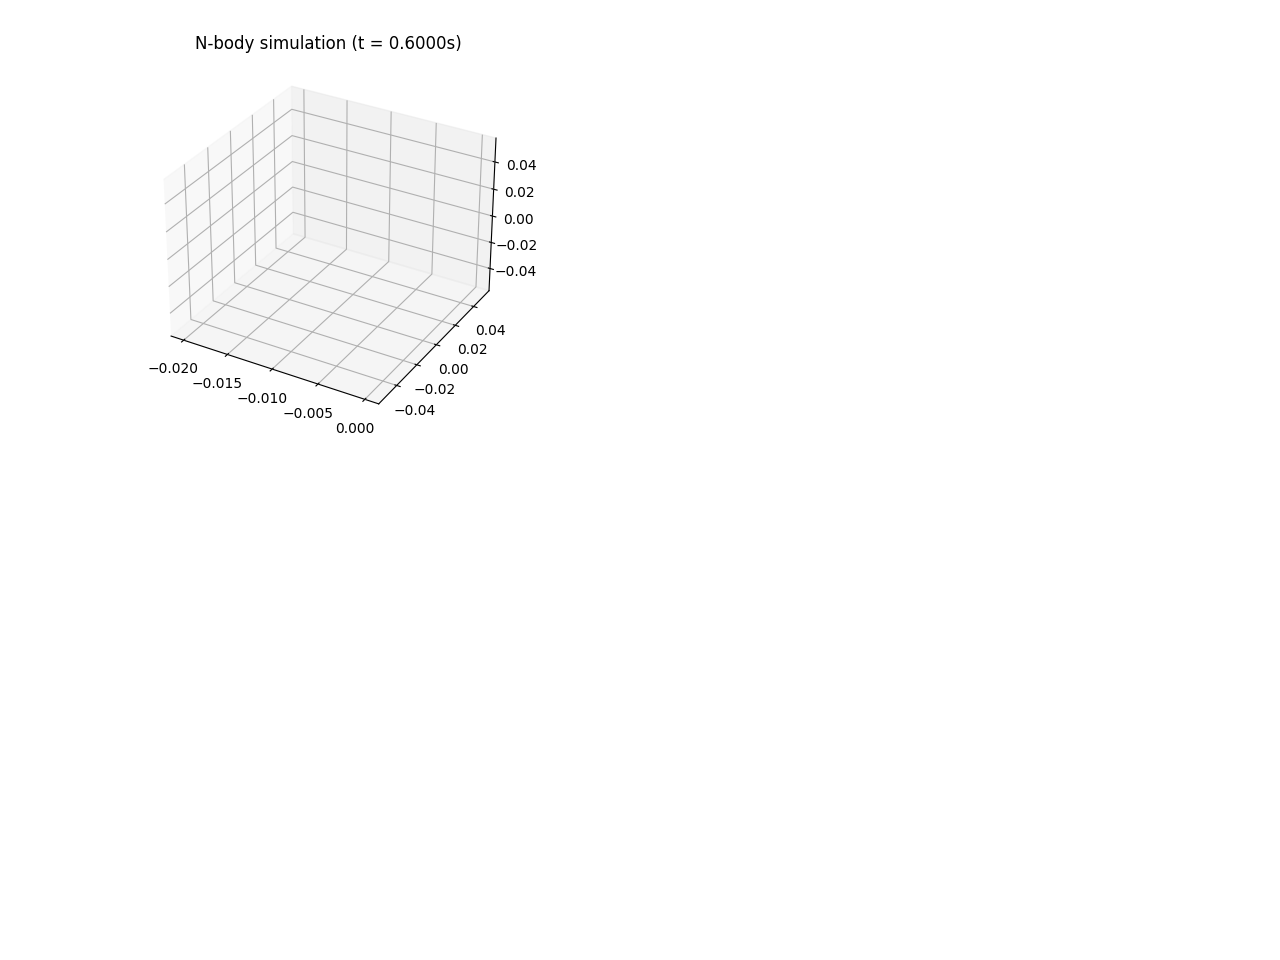

[[-0.00410166 -0.0214498 ]
 [-0.00299359 -0.00279508]
 [-0.00316135 -0.00293828]]
[[-0.01541994 -0.02647456]
 [-0.01116049 -0.01083214]
 [-0.0115333  -0.01115036]]
[[-0.03273856 -0.03322743]
 [-0.02361951 -0.02179935]
 [-0.02426297 -0.02229259]]
[[-0.05379974 -0.0444512 ]
 [-0.03920204 -0.03748953]
 [-0.04013205 -0.03795154]]
[[-0.07673942 -0.06200019]
 [-0.05731962 -0.05805285]
 [-0.05839216 -0.05872379]]
[[-0.10152085 -0.0863234 ]
 [-0.07858253 -0.08289282]
 [-0.08001515 -0.08407674]]


KeyboardInterrupt: 

In [11]:
#nbody = NBody(2, m=100, ngrid=65)
pos_init = np.array([[0.0, -0.02],[0.0, 0.0],[0.0, 0.0]])
#nbody = NBody(2, G=100, ngrid=51, v=[[0, 0],[0.0005, -0.0005],[0,0]], pos_init=pos_init, dx=0.1)
#nbody = NBody(2, G=100, ngrid=101, pos_init=pos_init, dx=0.01, soft=0.03)
nbody = NBody(2, ngrid=101, dx=0.01, soft=0.03, dt=0.01, pos_init=pos_init, G=0.001)

time = 0.0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('N-body simulation (t = %.4fs)' % time)
graph = ax.scatter(nbody.pos[0,:], nbody.pos[1,:], nbody.pos[2,:])

for _ in range(50):
    graph._offsets3d = (nbody.pos[0,:], nbody.pos[1,:], nbody.pos[2,:])
    ax.set_title('N-body simulation (t = %.4fs)' % time)
    #plt.pause(0.1)
    fig.canvas.draw()
    for _ in range(10):
        nbody.evolve()
        time += nbody.dt
    print(nbody.pos)

<IPython.core.display.Javascript object>


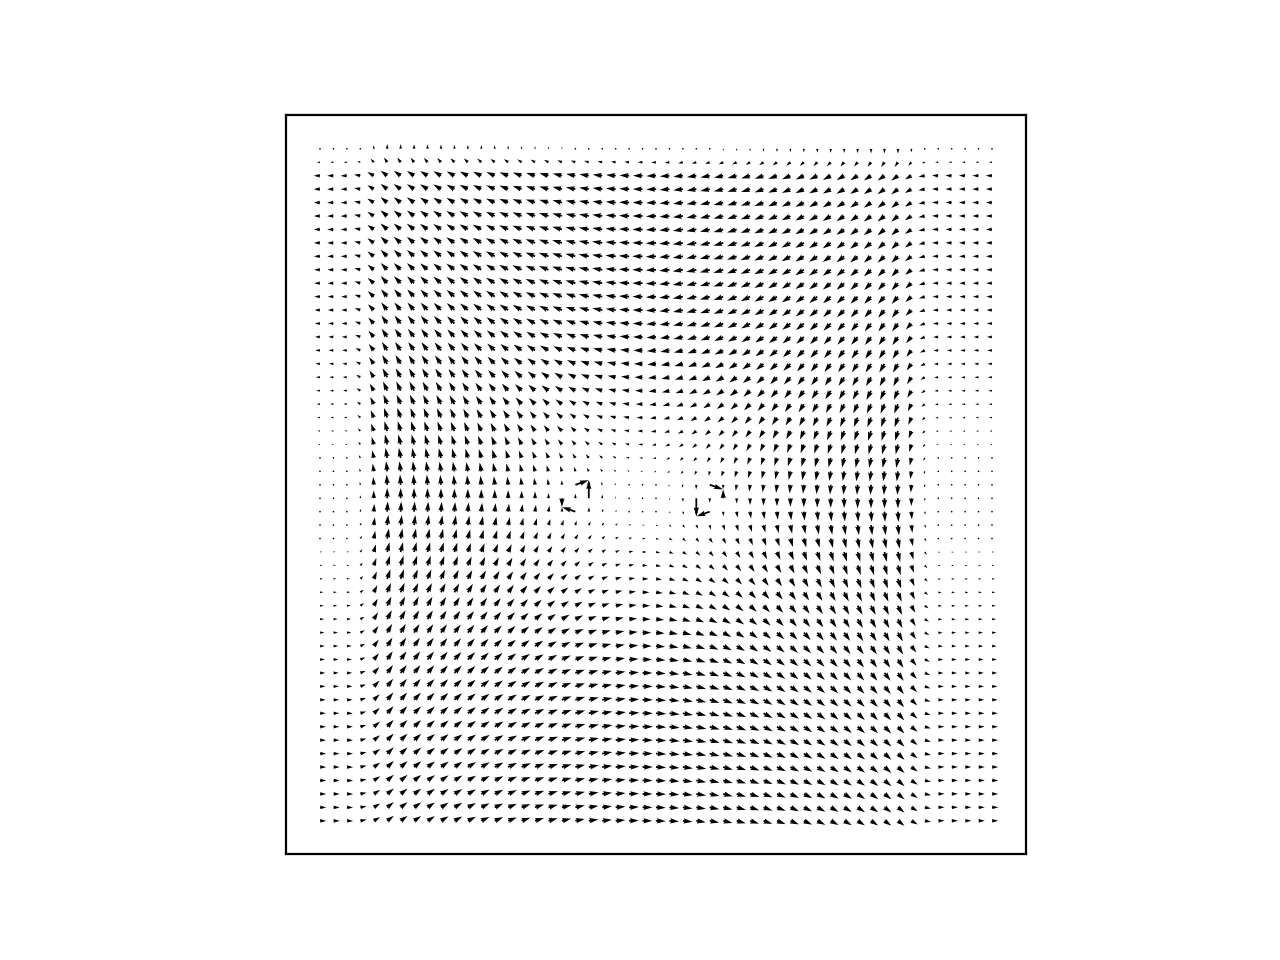

In [83]:
pos_init = np.array([[0.0, 0.0],[1.0, -1.0],[0.0, 0.0]])
nbody = NBody(2, m=1, ngrid=51, pos_init=pos_init, dx=0.1)
#np.max(nbody.get_forces())

pot = nbody.get_potential()
        
x = np.arange(pot.shape[0])
X, Y = np.meshgrid(x, x)

dx,dy,dz = np.gradient(pot)

fig, ax = plt.subplots()
ax.quiver(X, Y, -dx[:,:,0], -dy[:,:,0])
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_aspect('equal')
plt.show()

In [45]:
pot.sum()

0.0

<IPython.core.display.Javascript object>


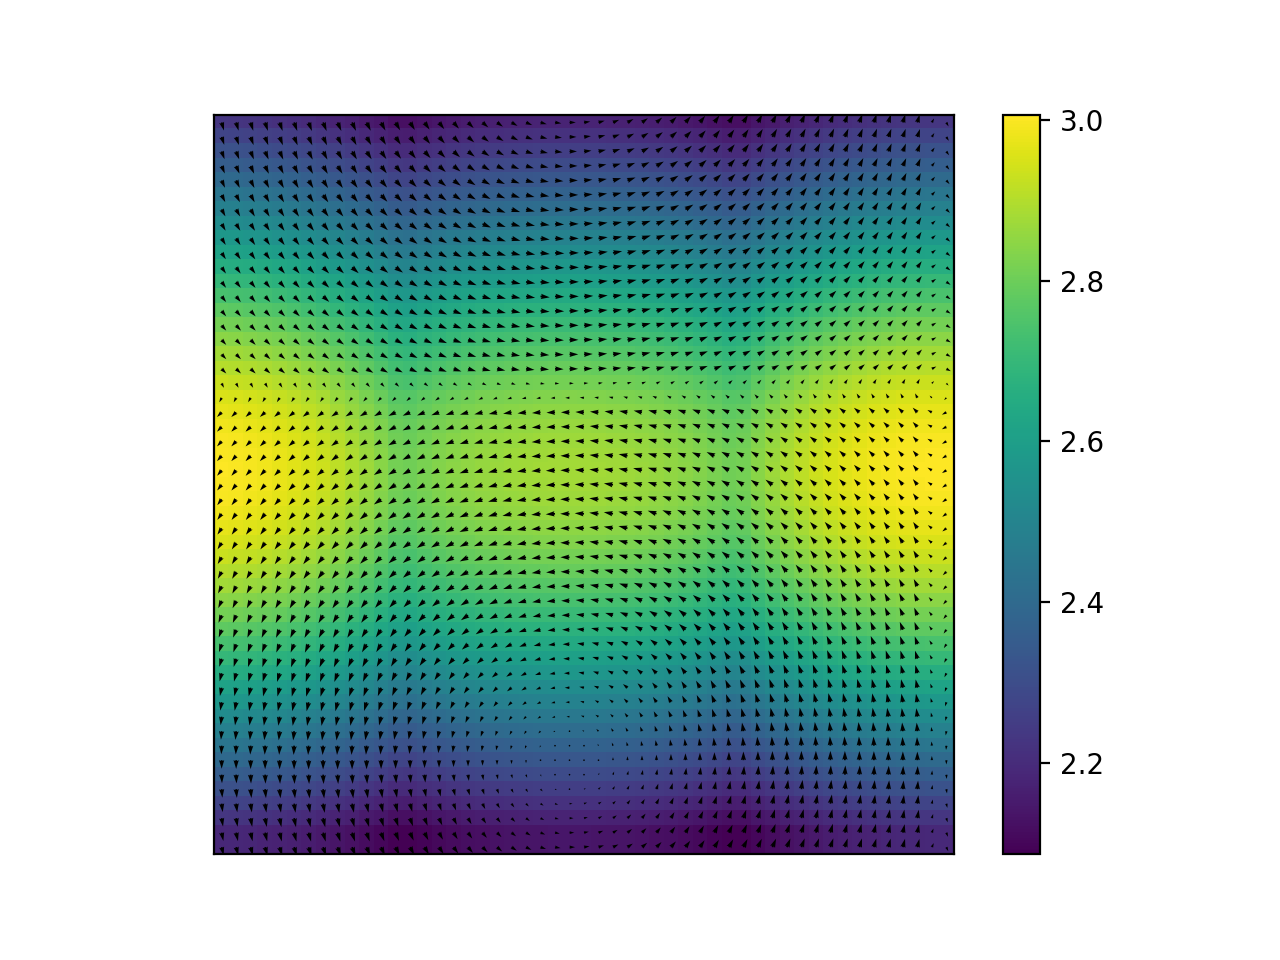

In [19]:
pos_init = np.array([[1.0],[0.0],[0.0]])
nbody = NBody(1, ngrid=51, dx=0.025, soft=0.1, dt=0.01, pos_init=pos_init, G=10000)
pot = nbody.get_potential()

x = np.arange(pot.shape[0])
X, Y = np.meshgrid(x, x)
#dx,dy,dz = np.gradient(pot)
dx = 0.5 * (np.roll(pot, 1, axis=0) - np.roll(pot, -1, axis=0)) / nbody.dx * nbody.G
dy = 0.5 * (np.roll(pot, 1, axis=1) - np.roll(pot, -1, axis=1)) / nbody.dx * nbody.G

fig, ax = plt.subplots()
ax.quiver(X, Y, -dx[:,:,0], -dy[:,:,0])
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_aspect('equal')
plt.show()

#fig = plt.subplots()
#plt.imshow(pot[:,:,0])
#plt.colorbar()
#plt.show()